# Maternal Health Risk Prediction(Nurture)
Despite advancements in healthcare, a concerning number of maternal deaths continue to occur, particularly in regions such as Sub-Saharan Africa (70%) and South Asia (16%). In 2020, approximately 287,000 women died from complications related to pregnancy, with Sub-Saharan Africa accounting for 70% of these fatalities. In Kenya, the maternal mortality rate remains high, ranging from 400 to 600 deaths per 100,000 live births. This rate far exceeds the global target set by the Sustainable Development Goals (SDG) Target 3.1, which aims to reduce maternal mortality to less than 70 per 100,000 live births by 2030.

One of the key challenges in addressing maternal health is the accurate identification and management of risk factors. This notebook aims to tackle this issue by predicting maternal risks for pregnant patients using specific features, such as age.

### Variables
**Age:** Age in years when a woman is pregnant.

**SystolicBP:** Upper value of Blood Pressure in mmHg, another significant attribute during pregnancy.

**DiastolicBP:** Lower value of Blood Pressure in mmHg, another significant attribute during pregnancy.

**BS:** Blood glucose levels is in terms of a molar concentration, mmol/L.

**HeartRate:** A normal resting heart rate in beats per minute.

**Body Temperature:** The temperature of the mother in Fahrenheit. 

**Risk Level:** Predicted Risk Intensity Level during pregnancy considering the previous attributes. Classified into three(high risk, low risk, mid risk)

### Steps Taken
1. Data loading.
2. Inspecting the data: Checking for missing values, getting the statistics and information of the data.
3. Encoding categorical variable.
4. Checking for outliers and handling them.
5. Scaling of features
6. Splitting into training and testing sets.
7. Building the model.
8. Saving the model.

# Data Preprocessing

In [3]:
## Importing Modules
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
import pickle
import os
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    mean_squared_error,
)

Dataset Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1014 entries, 0 to 1013
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Age          1014 non-null   int64  
 1   SystolicBP   1014 non-null   int64  
 2   DiastolicBP  1014 non-null   int64  
 3   BS           1014 non-null   float64
 4   BodyTemp     1014 non-null   float64
 5   HeartRate    1014 non-null   int64  
 6   RiskLevel    1014 non-null   object 
dtypes: float64(2), int64(4), object(1)
memory usage: 55.6+ KB
None

Missing Values:
Age            0
SystolicBP     0
DiastolicBP    0
BS             0
BodyTemp       0
HeartRate      0
RiskLevel      0
dtype: int64

Summary Statistics:
               Age   SystolicBP  DiastolicBP           BS     BodyTemp  \
count  1014.000000  1014.000000  1014.000000  1014.000000  1014.000000   
mean     29.871795   113.198225    76.460552     8.725986    98.665089   
std      13.474386    18.403913    

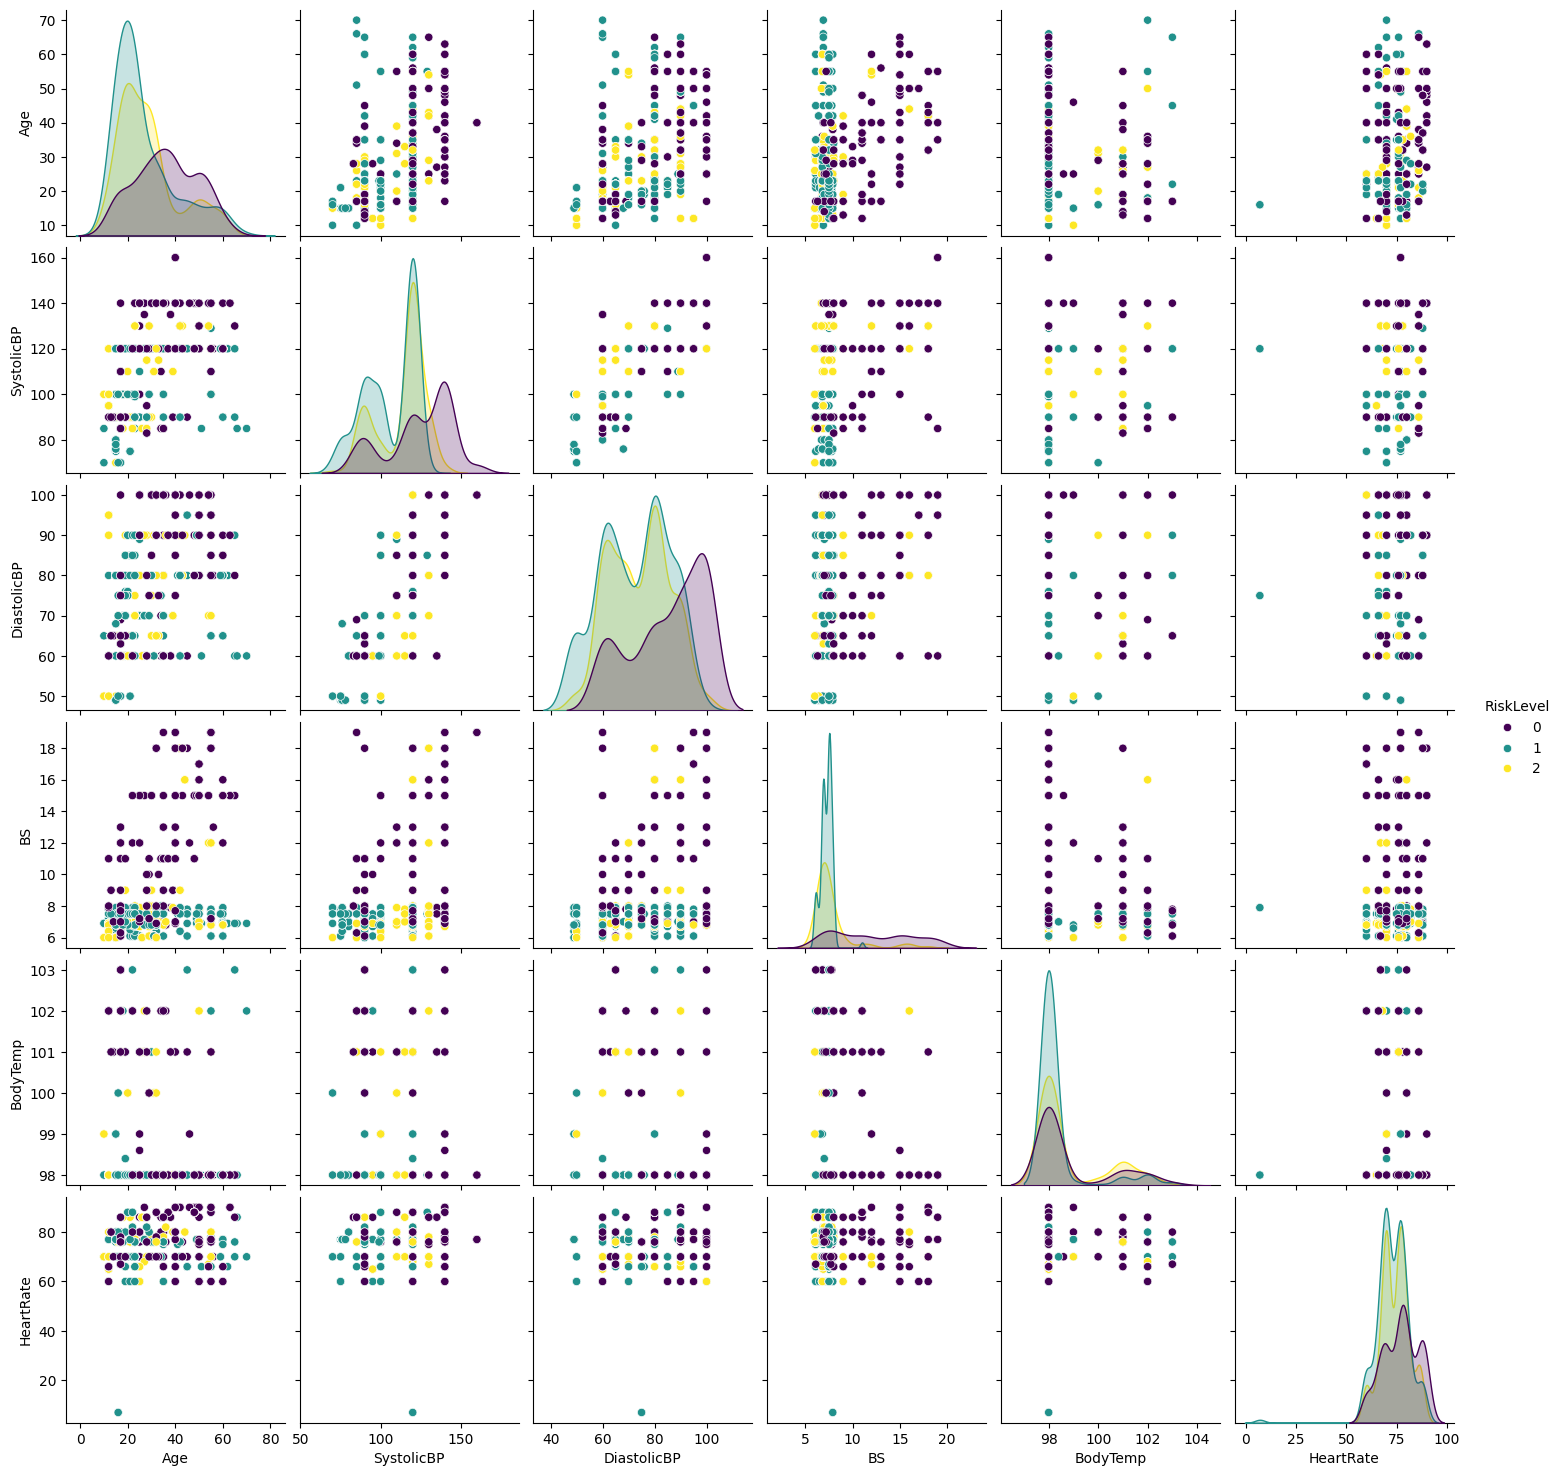

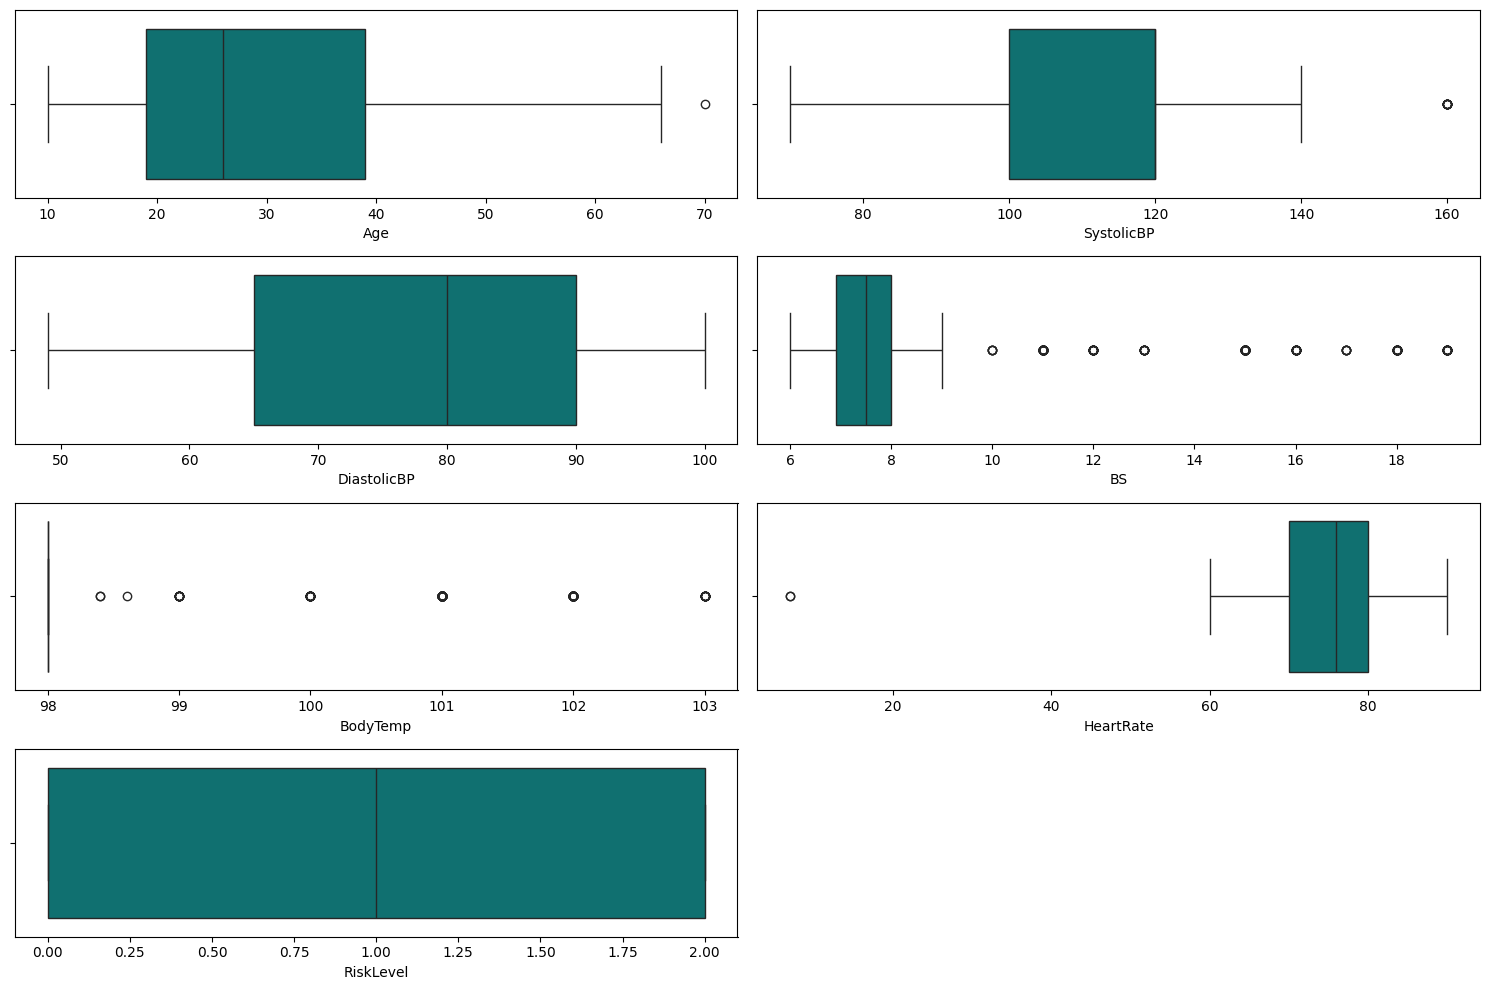


Preprocessing Completed!
Shapes:
X_train: (881, 6)
X_val: (163, 6)
X_test: (203, 6)
y_train: (881,)
y_val: (163,)
y_test: (203,)


In [4]:

# Function to load and inspect the dataset
def load_and_inspect_data(file_path):
    df = pd.read_csv(file_path)
    print("Dataset Information:")
    print(df.info())
    missing_values = df.isnull().sum()
    print("\nMissing Values:")
    print(missing_values)
    print("\nSummary Statistics:")
    print(df.describe())
    return df

# Function to encode categorical 'RiskLevel' column
def encode_risk_level(df):
    label_encoder = LabelEncoder()
    df['RiskLevel'] = label_encoder.fit_transform(df['RiskLevel'])
    return df, label_encoder

# Function to visualize the pairplot for dataset features
def plot_pairplot(df):
    sns.pairplot(df, hue="RiskLevel", palette="viridis", diag_kind="kde", height=2.5)
    plt.show()

# Function to visualize outliers using boxplots
def plot_boxplots(df):
    plt.figure(figsize=(15, 10))
    num_cols = len(df.columns)
    num_rows = (num_cols + 1) // 2
    for i, column in enumerate(df.columns, 1):
        plt.subplot(num_rows, 2, i)
        sns.boxplot(x=df[column], color='teal')
    plt.tight_layout()
    plt.show()

# Function to handle outliers by capping with IQR method
def cap_outliers(df):
    Q1 = df.quantile(0.25)
    Q3 = df.quantile(0.75)
    IQR = Q3 - Q1
    df_no_outliers = df.copy()
    for column in df.columns:
        lower_bound = Q1[column] - 1.5 * IQR[column]
        upper_bound = Q3[column] + 1.5 * IQR[column]
        df_no_outliers[column] = np.where(df[column] < lower_bound, lower_bound, df_no_outliers[column])
        df_no_outliers[column] = np.where(df[column] > upper_bound, upper_bound, df_no_outliers[column])
    return df_no_outliers

# Function to split data into train, validation, and test sets
def split_data(df):
    X = df.drop('RiskLevel', axis=1)
    y = df['RiskLevel']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42, stratify=y_train)
    return X_train, X_val, X_test, y_train, y_val, y_test

# Function to handle class imbalance using SMOTE
def handle_imbalance(X_train, y_train):
    smote = SMOTE(sampling_strategy={0: 406}, random_state=42)
    X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)
    return X_train_resampled, y_train_resampled

# Function to scale the features using StandardScaler
def scale_data(X_train_resampled, X_val, X_test):
    scaler = StandardScaler()
    X_train_resampled_scaled = scaler.fit_transform(X_train_resampled)
    X_val_scaled = scaler.transform(X_val)
    X_test_scaled = scaler.transform(X_test)
    with open('scaler.pkl', 'wb') as scaler_file:
        pickle.dump(scaler, scaler_file)
    return X_train_resampled_scaled, X_val_scaled, X_test_scaled

# Function to save training and test data to CSV
def save_data_to_csv(X_train, X_val, X_test, y_train, y_val, y_test):
    pd.DataFrame(X_train).to_csv('X_train.csv', index=False)
    pd.DataFrame(X_val).to_csv('X_val.csv', index=False)
    pd.DataFrame(X_test).to_csv('X_test.csv', index=False)
    pd.DataFrame(y_train).to_csv('y_train.csv', index=False)
    pd.DataFrame(y_val).to_csv('y_val.csv', index=False)
    pd.DataFrame(y_test).to_csv('y_test.csv', index=False)

# Main function that ties everything together
def preprocess_and_save(file_path):
    df = load_and_inspect_data(file_path)
    df, label_encoder = encode_risk_level(df)
    plot_pairplot(df)
    plot_boxplots(df)
    df_no_outliers = cap_outliers(df)
    X_train, X_val, X_test, y_train, y_val, y_test = split_data(df_no_outliers)
    X_train_resampled, y_train_resampled = handle_imbalance(X_train, y_train)
    X_train_resampled_scaled, X_val_scaled, X_test_scaled = scale_data(X_train_resampled, X_val, X_test)
    save_data_to_csv(X_train, X_val, X_test, y_train, y_val, y_test)
    return X_train_resampled_scaled, X_val_scaled, X_test_scaled, y_train_resampled, y_val, y_test, label_encoder

# Execute if script is run as the main module
if __name__ == "__main__":
    file_path = 'maternal_health_risk.csv'
    X_train_resampled_scaled, X_val_scaled, X_test_scaled, y_train_resampled, y_val, y_test, label_encoder = preprocess_and_save(file_path)
    print("\nPreprocessing Completed!")
    print(f"Shapes:\nX_train: {X_train_resampled_scaled.shape}\nX_val: {X_val_scaled.shape}\nX_test: {X_test_scaled.shape}")
    print(f"y_train: {y_train_resampled.shape}\ny_val: {y_val.shape}\ny_test: {y_test.shape}")


Created directory: ./models
Dataset Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1014 entries, 0 to 1013
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Age          1014 non-null   int64  
 1   SystolicBP   1014 non-null   int64  
 2   DiastolicBP  1014 non-null   int64  
 3   BS           1014 non-null   float64
 4   BodyTemp     1014 non-null   float64
 5   HeartRate    1014 non-null   int64  
 6   RiskLevel    1014 non-null   object 
dtypes: float64(2), int64(4), object(1)
memory usage: 55.6+ KB
None

Missing Values:
Age            0
SystolicBP     0
DiastolicBP    0
BS             0
BodyTemp       0
HeartRate      0
RiskLevel      0
dtype: int64

Summary Statistics:
               Age   SystolicBP  DiastolicBP           BS     BodyTemp  \
count  1014.000000  1014.000000  1014.000000  1014.000000  1014.000000   
mean     29.871795   113.198225    76.460552     8.725986    98.665089   
std    

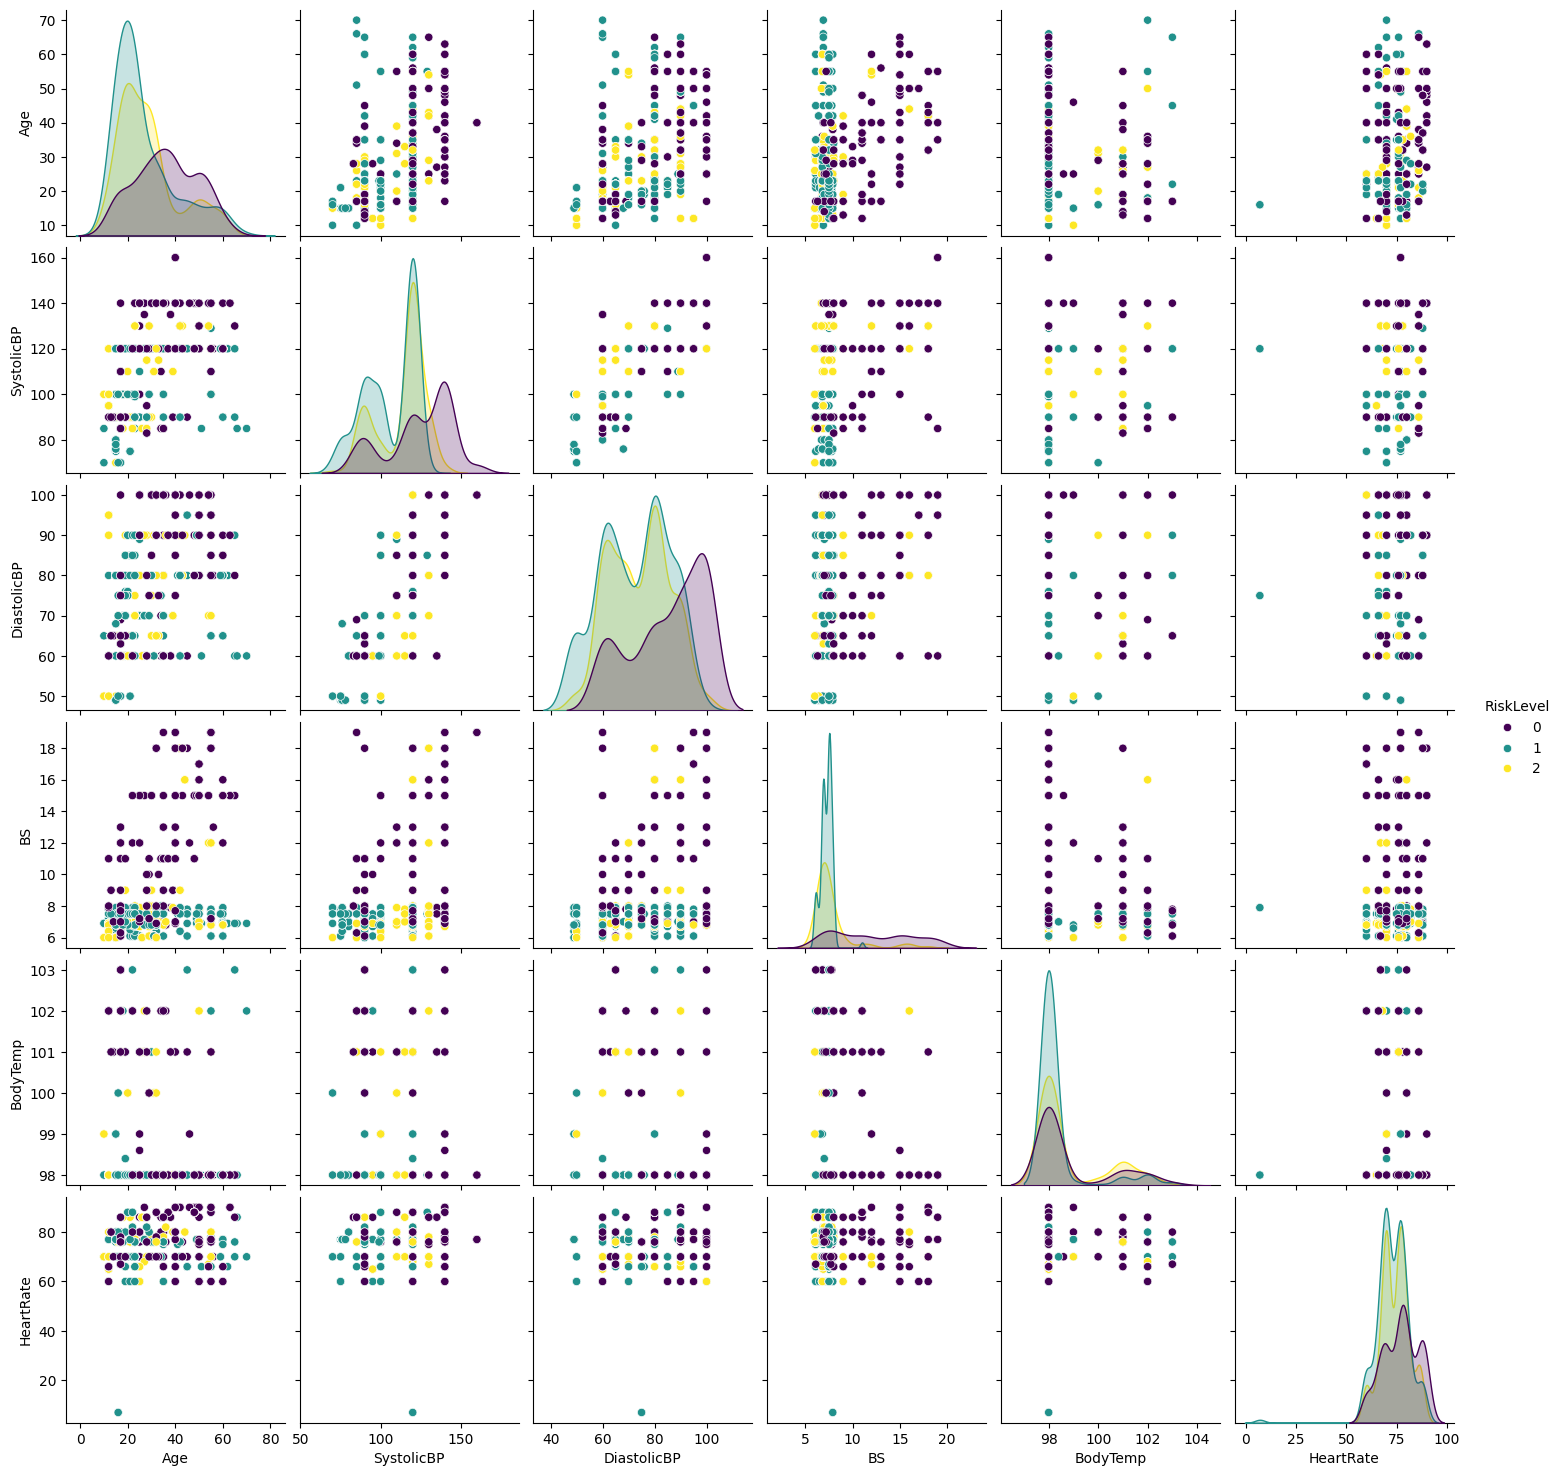

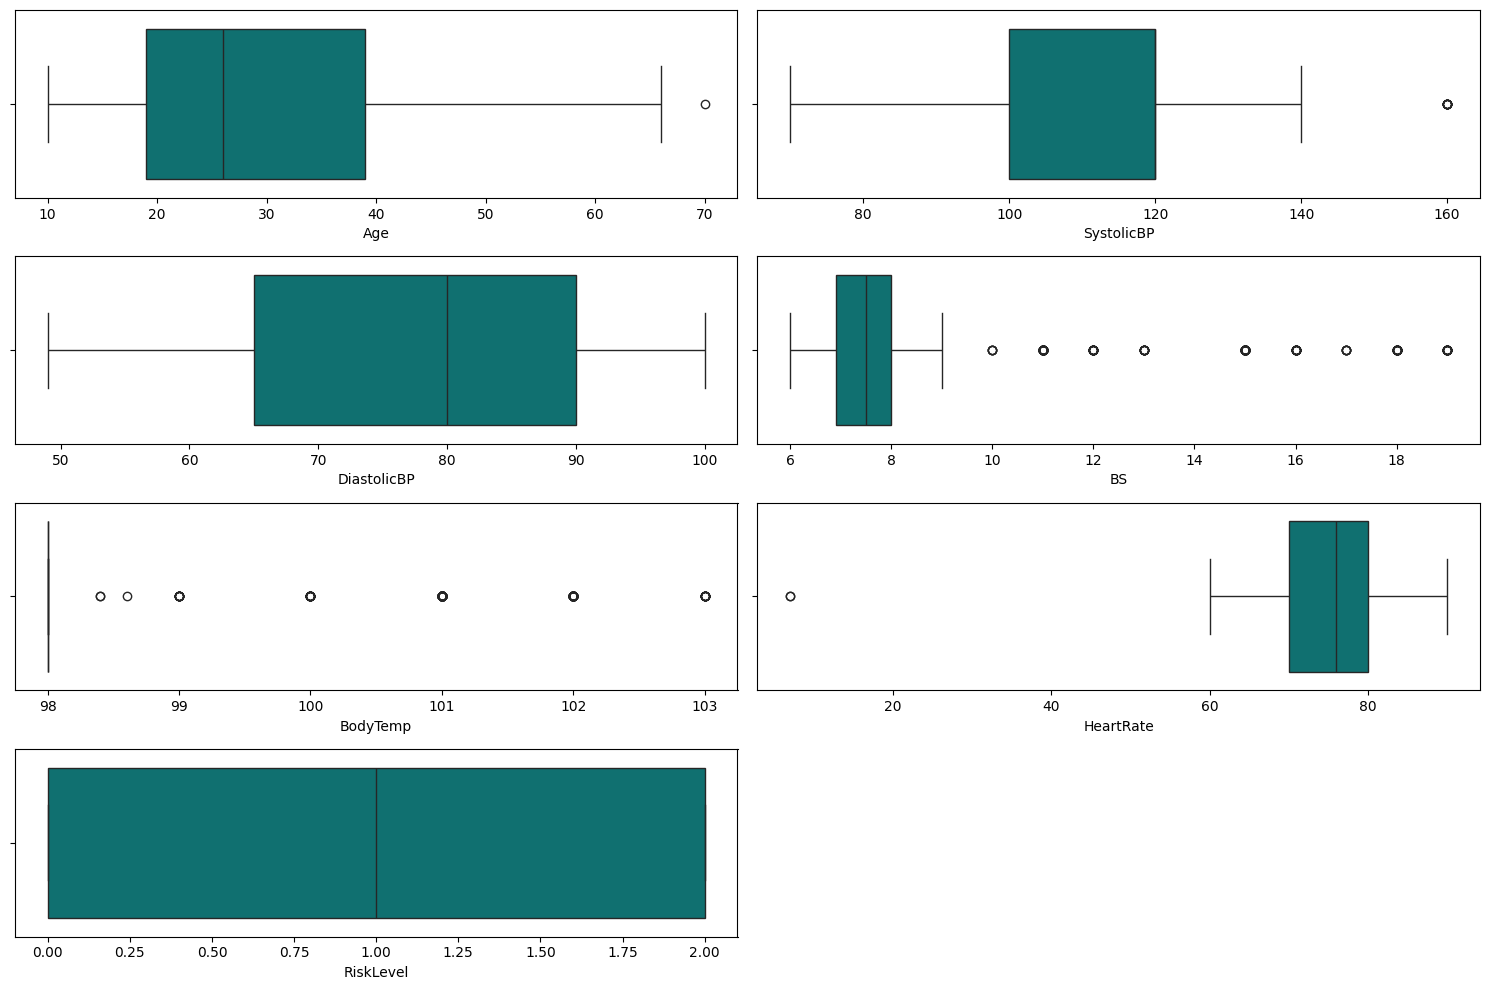


Validation Results:
Mean Squared Error (MSE): 0.3067484662576687
Validation Accuracy: 0.8404907975460123
Validation Confusion Matrix:
 [[40  1  3]
 [ 2 57  6]
 [ 5  9 40]]
Validation Classification Report:
               precision    recall  f1-score   support

   High Risk       0.85      0.91      0.88        44
    Low Risk       0.85      0.88      0.86        65
    Mid Risk       0.82      0.74      0.78        54

    accuracy                           0.84       163
   macro avg       0.84      0.84      0.84       163
weighted avg       0.84      0.84      0.84       163


Test Results:
Test Accuracy: 0.8423645320197044
Test Confusion Matrix:
 [[52  1  2]
 [ 2 64 15]
 [ 3  9 55]]
Test Classification Report:
               precision    recall  f1-score   support

   High Risk       0.91      0.95      0.93        55
    Low Risk       0.86      0.79      0.83        81
    Mid Risk       0.76      0.82      0.79        67

    accuracy                           0.84       203


In [5]:
def train_and_evaluate_model(filepath, model_dir='./models'):
    if not os.path.exists(model_dir):
        os.makedirs(model_dir)
        print(f"Created directory: {model_dir}")
        
    (X_train_resampled_scaled, X_val_scaled, X_test_scaled, y_train_resampled, y_val, y_test, label_encoder) = preprocess_and_save(filepath)
    
    # Initializing the Random forest Classifier
    model = RandomForestClassifier(n_estimators=100, random_state=42)
    model.fit(X_train_resampled_scaled, y_train_resampled)
    
    #Predictions on val set
    y_val_pred = model.predict(X_val_scaled)
    
    # Evaluation on val set
    mse = mean_squared_error(y_val, y_val_pred)
    val_accuracy = accuracy_score(y_val, y_val_pred)
    val_confusion_matrix = confusion_matrix(y_val, y_val_pred)
    val_classification_report = classification_report(
        y_val, y_val_pred, target_names=["High Risk", "Low Risk", "Mid Risk"]
    )

    print("\nValidation Results:")
    print("Mean Squared Error (MSE):", mse)
    print("Validation Accuracy:", val_accuracy)
    print("Validation Confusion Matrix:\n", val_confusion_matrix)
    print("Validation Classification Report:\n", val_classification_report)

    # Predictions on test set
    y_test_pred = model.predict(X_test_scaled)

    # Evaluate on test set
    test_accuracy = accuracy_score(y_test, y_test_pred)
    test_confusion_matrix = confusion_matrix(y_test, y_test_pred)
    test_classification_report = classification_report(
        y_test, y_test_pred, target_names=["High Risk", "Low Risk", "Mid Risk"]
    )

    print("\nTest Results:")
    print("Test Accuracy:", test_accuracy)
    print("Test Confusion Matrix:\n", test_confusion_matrix)
    print("Test Classification Report:\n", test_classification_report)

    # Save the trained model as a pickle file
    model_path = os.path.join(model_dir, "random_forest_model.pkl")
    if not os.path.exists(model_path):
        with open(model_path, "wb") as model_file:
            pickle.dump(model, model_file)
        print(f"\nModel saved to: {model_path}")
    else:
        print(f"\nModel already exists at: {model_path}. Skipping save.")

    print("Model training and evaluation completed!")
    return model, label_encoder



if __name__ == "__main__":
    file_path = "maternal_health_risk.csv"  
    trained_model, label_encoder = train_and_evaluate_model(file_path)

In [10]:
def load_trained_model(model_path="./models/random_forest_model.pkl"):
    """
    Load the trained Random Forest model.
    
    Args:
    model_path (str): Path to the saved model file.
    
    Returns:
    sklearn.ensemble.RandomForestClassifier: Loaded model.
    """
    with open(model_path, "rb") as model_file:
        model = pickle.load(model_file)
    return model

def load_label_encoder(encoder_path='../data/scaler/label_encoder.pkl'):
    """
    Load the LabelEncoder used for encoding the 'RiskLevel' labels.
    
    Args:
    encoder_path (str): Path to the saved label encoder.
    
    Returns:
    LabelEncoder: Loaded LabelEncoder.
    """
    with open(encoder_path, 'rb') as encoder_file:
        label_encoder = pickle.load(encoder_file)
    return label_encoder

def load_scaler(scaler_path="../data/scaler/scaler.pkl"):
    """
    Load the saved scaler for preprocessing.
    
    Args:
    scaler_path (str): Path to the saved scaler file.
    
    Returns:
    sklearn.preprocessing.StandardScaler: Loaded scaler.
    """
    with open(scaler_path, "rb") as scaler_file:
        scaler = pickle.load(scaler_file)
    return scaler

def predict(model, scaler, label_encoder, new_data):
    """
    Make predictions using the trained model and preprocess the input data.
    
    Args:
    model (sklearn model): Trained model.
    scaler (sklearn.preprocessing.StandardScaler): Scaler for input features.
    label_encoder (sklearn.preprocessing.LabelEncoder): Label encoder for decoding predictions.
    new_data (pd.DataFrame): New data for prediction.
    
    Returns:
    list: Predicted class labels.
    """
    new_data_scaled = scaler.transform(new_data)
    predictions = model.predict(new_data_scaled)
    
    # Ensure predictions are integers
    predictions = predictions.astype(int)
    
    # Decode predictions using LabelEncoder
    decoded_predictions = label_encoder.inverse_transform(predictions)
    return decoded_predictions

if __name__ == "__main__":
    # Load the model, scaler, and label encoder
    model = load_trained_model()
    label_encoder = load_label_encoder()
    scaler = load_scaler()

    # Example data for prediction (adjust the feature values as needed)
    example_data = pd.DataFrame({
        "Age": [25],
        "SystolicBP": [130],
        "DiastolicBP": [80],
        "BS": [15.00],
        "BodyTemp": [98.0],
        "HeartRate": [86],
    })

    # Make predictions
    predictions = predict(model, scaler, label_encoder, example_data)
    
    print("Prediction (Risk Level):", predictions[0])


Prediction (Risk Level): high risk


## Other Visualisations 

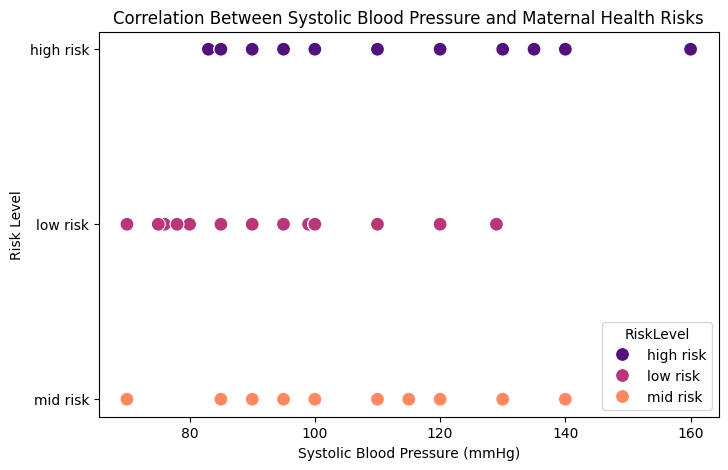

In [12]:
df = pd.read_csv('maternal_health_risk.csv')

# Plotting the scatter plot
plt.figure(figsize=(8, 5))
sns.scatterplot(data=df, x='SystolicBP', y='RiskLevel', hue='RiskLevel', palette='magma', s=100)
plt.title('Correlation Between Systolic Blood Pressure and Maternal Health Risks')
plt.xlabel('Systolic Blood Pressure (mmHg)')
plt.ylabel('Risk Level')
plt.show()


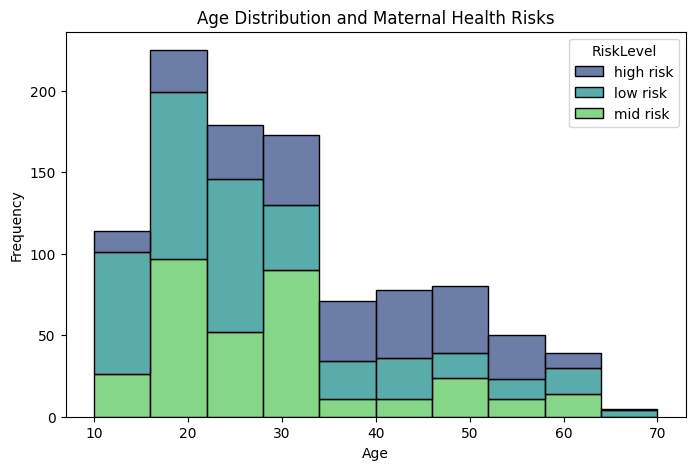

In [13]:
# Plotting the histogram
plt.figure(figsize=(8, 5))
sns.histplot(data=df, x='Age', hue='RiskLevel', multiple='stack', bins=10, palette='viridis')
plt.title('Age Distribution and Maternal Health Risks')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.savefig('age_distribution.png')  # Save the image
plt.show()


C:\Users\Administrator\AppData\Local\Temp\ipykernel_1016\418423796.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='RiskLevel', y='BS', palette='coolwarm')


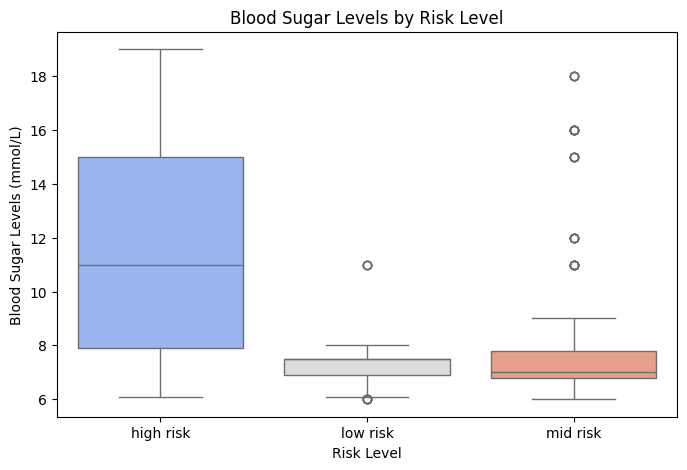

In [14]:
# Boxplot to visualize blood sugar levels by risk level
plt.figure(figsize=(8, 5))
sns.boxplot(data=df, x='RiskLevel', y='BS', palette='coolwarm')
plt.title('Blood Sugar Levels by Risk Level')
plt.xlabel('Risk Level')
plt.ylabel('Blood Sugar Levels (mmol/L)')
plt.savefig('blood_sugar_boxplot.png')  # Save the image
plt.show()


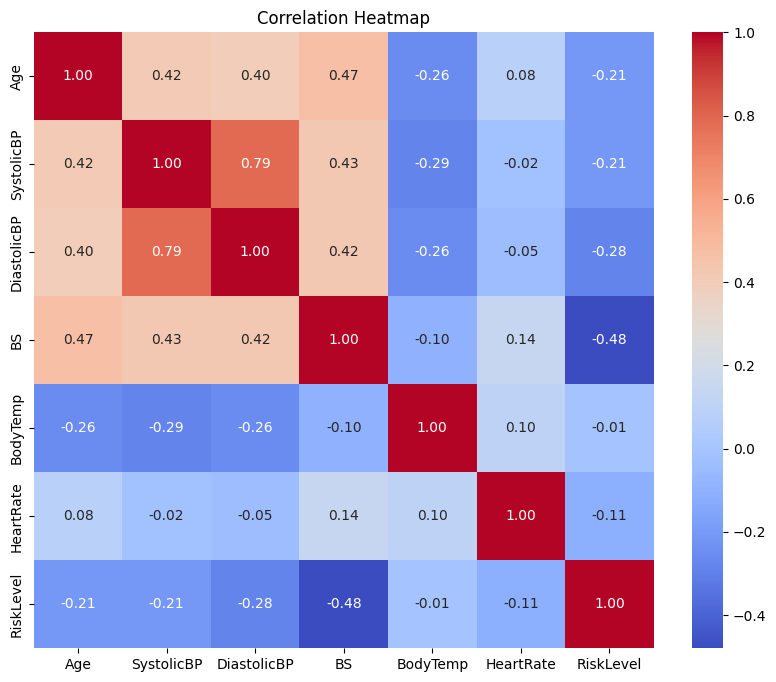

In [16]:
# Correlation heatmap

# Emcoding categorical variable in risklevel
from sklearn.preprocessing import LabelEncoder

# Initialize the LabelEncoder
label_encoder = LabelEncoder()

# Fit and transform the 'RiskLevel' column
df['RiskLevel'] = label_encoder.fit_transform(df['RiskLevel'])

correlation_matrix = df.corr()

# Create the heatmap
plt.figure(figsize=(10, 8))  # Adjust figure size as needed
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Heatmap")
plt.show()